In [1]:
### 0. Load Required Packages and Utility Functions
defaultW = getOption("warn") 
options(warn = -1) 
options(scipen = 10000)
suppressPackageStartupMessages({
    library(rstan)
    options(mc.cores = parallel::detectCores())
    rstan_options(auto_write = TRUE)
    Sys.setenv(LOCAL_CPPFLAGS = '-march=native')

    library(brms)
    library(lme4)
    library(here)
    library(tidyverse)
    library(tidybayes)
    library(bayesplot)
    library(lubridate)
    library(zoo)
    library(foreach)
    library(doParallel)
    library(doSNOW)
})

source("Packages/Utility_Functions_MMM.R")
source('Optimization_functions/common_functions_mmm.R')
source('Optimization_functions/compute_elasticity_&_contribution.r')
source('Optimization_functions/extract_media_params_for_optimization.R')
source('Optimization_functions/plot_model_metrics.R')

In [2]:
#load('model_fits/fit_PP_44_10_C1.RData')
load("RData/data_XyZ_ts_comp.RData")
load("RData/pp_MMM_ts_comp_xy995.RData")

In [3]:
target_cols            = c('gross_add_true')
media_spend_cols             = c("radio_spend","tv_spend","print_spend","dm_spend","audio_spend",
                      "display_spend","video_spend","paid_search_spend_brand", 
                      "paid_search_spend_unbranded","social_spend")

target_norm_cols_vec = c('non_sub')
nbr_period_q <- 13

In [4]:
data_XyZ <- get_quarters(data_XyZ_ts_comp)

`summarise()` has grouped output by 'dma'. You can override using the `.groups` argument.



In [5]:
mean_qy_spend <- data_XyZ %>%
                    select(qy,dma,media_spend_cols) %>%
                    group_by(qy,dma) %>%
                    summarize_at(.vars = vars(media_spend_cols),.funs = sum) %>%
                    group_by(dma) %>%
                    summarize_at(.vars = vars(media_spend_cols),.funs = mean) %>%
                    #mutate_at(.vars = vars(media_spend_cols),.funs = ~./nbr_period_q) %>%
                    as.data.frame()
mean_qy_spend

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(media_spend_cols)` instead of `media_spend_cols` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



dma,radio_spend,tv_spend,print_spend,dm_spend,audio_spend,display_spend,video_spend,paid_search_spend_brand,paid_search_spend_unbranded,social_spend
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABILENE-SWEETWATER TX,14175.550,106546.19,6205.3542,76923.47,305.64066,22386.175,13552.554,28892.64,42683.25,11230.668
ALEXANDRIA LA,16637.793,124594.70,3825.2124,85704.23,217.94069,13449.889,12445.923,26540.01,40283.06,12830.574
All Other Suddenlink DMA Total,145773.334,258618.40,16641.8546,326039.34,21246.39902,334723.982,182099.773,129619.17,394801.66,98732.791
AMARILLO TX,25603.713,147992.09,18240.0636,158723.01,456.46176,35134.720,20031.456,40630.99,50759.40,20322.126
AUSTIN TX,75379.090,0.00,13526.7744,107789.71,1687.35979,92867.537,48737.207,38996.82,132474.35,22484.941
BLUEFIELD-BECKLEY-OAK HILL WV,27548.527,103823.96,1678.5735,77789.80,249.90208,24311.689,14454.061,27723.32,35206.31,13170.056
CHARLESTON-HUNTINGTON WV,28192.823,164182.08,4815.9718,154027.96,930.52536,64981.544,47087.079,68971.54,99161.18,38643.930
DALLAS-FT WORTH TX,96678.177,0.00,31890.2384,274569.17,5552.81791,240242.861,112481.041,87402.00,282042.90,54141.245
EUREKA CA,12527.670,93607.90,1565.7424,49734.69,287.59660,14270.601,8798.194,16481.42,12864.55,2984.546


In [6]:
##Computing the mean weekly spend by excluding the zero weeks
mean_weekly_spend <- data_XyZ %>%
                     group_by(dma) %>%
                     summarize_at(.vars = vars(media_spend_cols), .funs = exclude_zero_spend_weeks)
mean_weekly_spend

dma,radio_spend,tv_spend,print_spend,dm_spend,audio_spend,display_spend,video_spend,paid_search_spend_brand,paid_search_spend_unbranded,social_spend
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABILENE-SWEETWATER TX,1236.2398,8195.861,2737.656,5917.190,64.57197,1722.0135,1047.8779,2233.9671,3300.252,877.3959
ALEXANDRIA LA,1494.4126,9584.207,1509.952,6592.633,52.72759,1034.6068,957.3787,2041.5391,3098.697,997.1948
All Other Suddenlink DMA Total,12566.6668,19893.723,6569.153,25079.950,2591.02427,25747.9986,14007.6749,9970.7054,30369.359,7594.8301
AMARILLO TX,2064.8156,11384.007,4412.919,12209.463,120.12152,2702.6707,1581.4308,3125.4609,3924.696,1571.2984
AUSTIN TX,9663.9859,0.000,2898.595,8291.516,328.70645,7217.6843,3787.8658,2999.7556,10190.335,1738.5264
BLUEFIELD-BECKLEY-OAK HILL WV,2459.6899,7986.458,2098.217,5983.831,48.68222,1870.1299,1111.8508,2132.5630,2708.178,1013.0812
CHARLESTON-HUNTINGTON WV,2547.5443,12629.391,3439.980,11848.305,199.39829,5024.3462,3640.7536,5305.5029,7627.783,2987.9328
DALLAS-FT WORTH TX,11329.4738,0.000,6464.238,21120.705,925.46965,18480.2201,8652.3878,6723.2309,21695.607,4164.7112
EUREKA CA,1196.9111,7200.608,1565.742,3825.745,64.38730,1097.7386,680.2727,1274.3364,1005.043,230.7639


In [7]:
##Computing number of weeks spend by DMA
mean_n_weeks <- data_XyZ %>%
                group_by(qy,dma) %>%
                summarize_at(.vars = vars(media_spend_cols), .funs = ~sum(ifelse(.!=0,1,0))) %>%
                group_by(dma) %>%
                summarize_at(.vars = vars(media_spend_cols), .funs = mean) 
mean_n_weeks

dma,radio_spend,tv_spend,print_spend,dm_spend,audio_spend,display_spend,video_spend,paid_search_spend_brand,paid_search_spend_unbranded,social_spend
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABILENE-SWEETWATER TX,11.466667,13.000000,2.2666667,13.00000,4.733333,13.00000,12.93333,12.93333,12.93333,12.80000
ALEXANDRIA LA,11.133333,13.000000,2.5333333,13.00000,4.133333,13.00000,13.00000,13.00000,13.00000,12.86667
All Other Suddenlink DMA Total,11.600000,13.000000,2.5333333,13.00000,8.200000,13.00000,13.00000,13.00000,13.00000,13.00000
AMARILLO TX,12.400000,13.000000,4.1333333,13.00000,3.800000,13.00000,12.66667,13.00000,12.93333,12.93333
AUSTIN TX,7.800000,0.000000,4.6666667,13.00000,5.133333,12.86667,12.86667,13.00000,13.00000,12.93333
BLUEFIELD-BECKLEY-OAK HILL WV,11.200000,13.000000,0.8000000,13.00000,5.133333,13.00000,13.00000,13.00000,13.00000,13.00000
CHARLESTON-HUNTINGTON WV,11.066667,13.000000,1.4000000,13.00000,4.666667,12.93333,12.93333,13.00000,13.00000,12.93333
DALLAS-FT WORTH TX,8.533333,0.000000,4.9333333,13.00000,6.000000,13.00000,13.00000,13.00000,13.00000,13.00000
EUREKA CA,10.466667,13.000000,1.0000000,13.00000,4.466667,13.00000,12.93333,12.93333,12.80000,12.93333


## PP_44_10_C19_xy995_appr3_45

In [8]:
load('Optimization_results/Optimizer_PP_44_10_C19_appr3_45_beta_res_xy995.RData')

In [9]:
load('MCMC_objs/MCMC_objs_EVA_PP_44_10_C19_xy995_appr3_beta_res.rda')

In [10]:
MCMC_beta_media <- MCMC_objs$beta_media
MCMC_beta_base_control <- MCMC_objs$beta_base_control
MCMC_alpha_K_S <- MCMC_objs$alpha_K_S
fit_metrics_df <- MCMC_objs$eval_metrics

In [12]:
## Naming the model results with the corresponding actual target name
## Get the geo dfs list
names_geo_df           = ls(pattern='*44_10_C19_appr3.*geo_para')
res_geo_df_list        = c()
res_geo_df_list        <- lapply(names_geo_df,FUN = function(x){append(res_geo_df_list,setNames(list(as.data.frame(get(x))),x),0)})
names(res_geo_df_list) = target_cols

## Get the population dfs list
names_pop_df           = ls(pattern='*44_10_C19_appr3.*pop_para')
res_pop_df_list        = c()
res_pop_df_list        <- lapply(names_pop_df,FUN = function(x){append(res_pop_df_list,setNames(list(as.data.frame(get(x))),x),0)})
names(res_pop_df_list) = target_cols
target_norm_cols <- 'non_sub'

In [13]:
names_geo_df
names_pop_df

[1] "PP_44_10_C19_appr3_45_beta_res_geo_para_stat"

[1] "PP_44_10_C19_appr3_45_beta_res_pop_para_stat"

In [14]:
test_extraction <- make_optim_data_mmm(data_XyZ              = data_XyZ,
                                               list_pop_param_df     = res_pop_df_list,
                                               list_geo_param_df     = res_geo_df_list,
                                               target_names_vec      = target_cols,
                                               list_preprocessed_data= pp_MMM_ts_comp_xy995,
                                               media_norm_type       = 4,
                                               target_norm_type      = 4,
                                               pooling_type = 'partial',
                                               target_norm_cols = target_norm_cols
                                               )

DMA names:
1 ABILENE-SWEETWATER TX
2 ALEXANDRIA LA
3 All Other Suddenlink DMA Total
4 AMARILLO TX
5 AUSTIN TX
6 BLUEFIELD-BECKLEY-OAK HILL WV
7 CHARLESTON-HUNTINGTON WV
8 DALLAS-FT WORTH TX
9 EUREKA CA
10 GREENVILLE-NEW BERN-WASH NC
11 HOUSTON TX
12 JONESBORO AR
13 LAKE CHARLES LA
14 LITTLE ROCK AR
15 LUBBOCK TX
16 MONROE-EL DORADO LA-AR
17 NEW YORK, NY
18 ODESSA-MIDLAND TX
19 OKLAHOMA CITY OK
20 PARKERSBURG WV
21 PHOENIX AZ
22 RALEIGH-DURHAM NC
23 SAN ANGELO TX
24 SHREVEPORT LA
25 SPRINGFIELD MO
26 ST JOSEPH MO
27 TULSA OK
28 TYLER-LONGVIEW TX
29 VICTORIA TX
30 WACO-TEMPLE-BRYAN TX
media names:
1 tv_spend
2 dm_spend
3 paid_search_spend_brand
4 paid_search_spend_unbranded
5 display_spend
6 radio_spend
7 video_spend
8 print_spend
9 social_spend
10 audio_spend

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(final_data_cols)` instead of `final_data_cols` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Adding missing grouping variables: `dma_id`, `dma`, `X`

Adding missing grouping variables: `dma_id`, `dma`, `X`

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(control_names_vec)` instead of `control_names_vec` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



In [15]:
# Outputs from `make_optim_data_mmm`
spend_cols_vec    = test_extraction$gross_add_true$media$spend_cols_vec
media_names_vec   = test_extraction$gross_add_true$media$media_names_vec
dma_names_vec     = test_extraction$gross_add_true$other$dma_names_vec
common_params_df  = test_extraction$gross_add_true$media$common_params_df
beta_media_mat    = test_extraction$gross_add_true$media$beta_media_mat
beta_control_mat  = test_extraction$gross_add_true$control$beta_control_mat
min_media_mat     = test_extraction$gross_add_true$media$min_media_mat
max_media_mat     = test_extraction$gross_add_true$media$max_media_mat
prospect_df       = test_extraction$gross_add_true$other$prospect_df
control_names_vec = test_extraction$gross_add_true$control$control_names_vec
control_mat       = test_extraction$gross_add_true$control$control_matrix
target_max_vec    = test_extraction$gross_add_true$target$target_max_vec
subs_col          = test_extraction$gross_add_true$other$subs_col
cleaned_names_list = test_extraction$gross_add_true$media$cleaned_media_names_vec
target_capita_norm_col = test_extraction$gross_add_true$target$target_capita_norm_col

In [16]:
prospect_vec = prospect_df[['non_sub']]
prospect_mat_media = matrix(prospect_vec,nrow = length(dma_names_vec), ncol = length(media_names_vec))

In [17]:
#*************  Simulator for Optimization  ***************************

###################################################################################################################################
#Global parameters needed for optimization
###################################################################################################################################
##Vector of Optimum DMA
optimum_dma =  c('NEW YORK, NY')
non_tv_dmas = mean_weekly_spend %>%
                mutate(dma_id = row_number(dma)) %>%
                filter(tv_spend == 0) %>%
                select(dma_id) %>%
                pull()


# media_names_vec = c('cross_channel','DM','outbound_call')


##Spend to activity ratio dataframe by DMA and media. Used primarily for activity based models for converting the activity to spend for optimization_ Dim - ndma*nmedia
spend_activity_ratio_dma_df <- as.data.frame(matrix(1, length(dma_names_vec), length(media_names_vec)))
colnames(spend_activity_ratio_dma_df) <- media_names_vec
spend_activity_ratio_dma_df[non_tv_dmas,'tv'] <- 0 

##Shape parameters used for GA calculation

K = common_params_df$K
S = common_params_df$S
alpha = common_params_df$alpha


##Spend dataframe
# data.XyZ = read.csv('MMA_final_data_with_30DMAs_v7.csv')
# data.XyZ = data.XyZ %>% 
#             #dplyr::select(-X) %>%
#             dplyr::rename(period = calendar_month, dma = DMA) %>%
#             dplyr::mutate(brand  = ifelse(dma == "NEW YORK, NY", "Optimum", "Suddenlink"),
#                           period = lubridate::as_date(period)) %>% 
#             dplyr::select(brand, dma, period, everything()) %>% 
#             dplyr::arrange(dma, period)


##Count of DMAs,medias and periods
nbr_media    = length(media_names_vec)
nbr_dma      = length(dma_names_vec)
nbr_periods  = data_XyZ %>% select(period) %>% distinct() %>% count(n()) %>% pull()
nbr_period_q = 13
n_weeks_mat = mean_n_weeks %>% rename_at(.vars = vars(spend_cols_vec), .funs = ~media_names_vec) %>% select(media_names_vec) %>% as.matrix()

target_var = 'weekly_gross_adds'
var_id_opt = which(dma_names_vec %in% optimum_dma)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(spend_cols_vec)` instead of `spend_cols_vec` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(media_names_vec)` instead of `media_names_vec` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



In [18]:
n_weeks_mat

tv,dm,paid_search_brand,paid_search_unbranded,display,radio,video,print,social,audio
13.000000,13.00000,12.93333,12.93333,13.00000,11.466667,12.93333,2.2666667,12.80000,4.733333
13.000000,13.00000,13.00000,13.00000,13.00000,11.133333,13.00000,2.5333333,12.86667,4.133333
13.000000,13.00000,13.00000,13.00000,13.00000,11.600000,13.00000,2.5333333,13.00000,8.200000
13.000000,13.00000,13.00000,12.93333,13.00000,12.400000,12.66667,4.1333333,12.93333,3.800000
0.000000,13.00000,13.00000,13.00000,12.86667,7.800000,12.86667,4.6666667,12.93333,5.133333
13.000000,13.00000,13.00000,13.00000,13.00000,11.200000,13.00000,0.8000000,13.00000,5.133333
13.000000,13.00000,13.00000,13.00000,12.93333,11.066667,12.93333,1.4000000,12.93333,4.666667
0.000000,13.00000,13.00000,13.00000,13.00000,8.533333,13.00000,4.9333333,13.00000,6.000000
13.000000,13.00000,12.93333,12.80000,13.00000,10.466667,12.93333,1.0000000,12.93333,4.466667
13.000000,13.00000,13.00000,13.00000,13.00000,10.200000,13.00000,1.6666667,12.66667,4.666667


In [19]:
model_params = list(
'media_params' = list(
'media_names_vec' = media_names_vec,
'beta_media_mat' = beta_media_mat,
'prospect_mat_media' = prospect_mat_media,
'K' = K,
'S' = S,
'alpha' = alpha,
'max_media_mat' = max_media_mat,
'min_media_mat' = min_media_mat,
'cleaned_names_list' = cleaned_names_list,
'spend_activity_ratio_dma_df' = spend_activity_ratio_dma_df,
'spend_cols_vec' = spend_cols_vec,
'n_weeks_mat' = n_weeks_mat
),
'control_params' = list(
'control_mat' = control_mat,
'control_names_vec' = control_names_vec,
'beta_control_mat' = beta_control_mat
),
'target_params' = list(
'target_var' = target_var,
'target_max_vec' = target_max_vec,
'target_capita_norm_col' = target_capita_norm_col
),    
'other_params' = list(
'nbr_period_q' = nbr_period_q,
'dma_names_vec' = dma_names_vec,
'optimum_dma' = optimum_dma
)
)

In [20]:
n_media = length(media_names_vec)
n_geo = length(dma_names_vec)
n_control = length(control_names_vec)

In [21]:
var_media = model_params$media_params$spend_cols_vec
var_media

[1] "tv_spend"                    "dm_spend"                   
 [3] "paid_search_spend_brand"     "paid_search_spend_unbranded"
 [5] "display_spend"               "radio_spend"                
 [7] "video_spend"                 "print_spend"                
 [9] "social_spend"                "audio_spend"

In [22]:
fit_metrics_mean_df <- fit_metrics_df %>%
                        mutate(group = toupper(group),
                               metric = toupper(metric)) %>%
                        filter(metric %in% c('R2','MAPE') & sample_type == 'Train') %>%
                        select(dma = group,metric,Mean) %>%
                        spread(metric,Mean)

fit_metrics_mean_df

dma,MAPE,R2
<chr>,<dbl>,<dbl>
ABILENE-SWEETWATER TX,9.805242,0.5987224
ALEXANDRIA LA,18.572959,0.6111950
ALL OTHER SUDDENLINK DMA TOTAL,9.723881,0.4198049
ALTICE,4.796981,0.8007981
AMARILLO TX,8.153682,0.6366264
AUSTIN TX,9.575441,0.8219841
BLUEFIELD-BECKLEY-OAK HILL WV,10.139894,0.5835260
CHARLESTON-HUNTINGTON WV,8.570880,0.5298610
DALLAS-FT WORTH TX,8.841308,0.7807145


### Computing using the mean of all parameters

In [23]:
res <- compute_elasticity_and_contribution(model_params = model_params,
                                              mean_qy_spend = mean_qy_spend,
                                            mean_weekly_spend = mean_weekly_spend,
                                           activity_based_media = NULL,
                                           data_XyZ = data_XyZ,
                                             spend_change = c(0.1,0.3))

`summarise()` has grouped output by 'dma'. You can override using the `.groups` argument.

Adding missing grouping variables: `qy`

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(control_names)` instead of `control_names` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

`summarise()` has grouped output by 'dma'. You can override using the `.groups` argument.

Adding missing grouping variables: `qy`

`summarise()` has grouped output by 'dma'. You can override using the `.groups` argument.

Adding missing grouping variables: `qy`

`summarise()` has grouped output by 'dma'. You can override using the `.groups` argument.

Adding missing grouping variables: `qy`

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(display_order)` instead of `display_order` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.

Order of media:
1.tv
2.dm
3.paid_search_brand
4.paid_search_unbranded
5.display
6.radio
7.video
8.print
9.social
10.audio
11.total

In [24]:
res$Elasticity$`Elasticity_up_0.1`

dma,tv,dm,paid_search_brand,paid_search_unbranded,display,radio,video,print,social,audio,spend_media_total
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALTICE,0.24,0.09,0.38,0.06,0.04,0.02,0.02,0.05,0.02,0.01,0.14
SUDDENLINK,0.19,0.06,0.47,0.07,0.03,0.03,0.01,0.06,0.01,0.01,0.11
OPTIMUM,0.29,0.11,0.32,0.05,0.04,0.00,0.03,0.00,0.03,0.00,0.17
ABILENE-SWEETWATER TX,0.15,0.04,0.55,0.02,0.00,0.00,0.00,0.06,0.01,0.00,0.11
ALEXANDRIA LA,0.21,0.05,0.23,0.02,0.00,0.00,0.00,0.03,0.01,0.00,0.11
All Other Suddenlink DMA Total,0.34,0.07,0.34,0.19,0.10,0.02,0.04,0.05,0.04,0.03,0.15
AMARILLO TX,0.18,0.05,0.46,0.01,0.00,0.00,0.00,0.05,0.01,0.00,0.10
AUSTIN TX,NaN,0.06,0.40,0.15,0.06,0.09,0.02,0.06,0.02,0.00,0.11
BLUEFIELD-BECKLEY-OAK HILL WV,0.21,0.04,0.36,0.01,0.00,0.01,0.00,0.04,0.01,0.00,0.11


In [25]:
res$All_metrics_detailed

dma,media,mean_spend,Media_GA,Media_contribution,mean_spend_up_0.1,Media_GA_up_0.1,mean_spend_down_0.1,Media_GA_down_0.1,mean_spend_up_0.3,Media_GA_up_0.3,mean_spend_down_0.3,Media_GA_down_0.3,control_ga,Elasticity_up_0.1,Elasticity_down_0.1,Elasticity_up_0.3,Elasticity_down_0.3
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALTICE,tv,12815856,14865.3208701,68.72,14097442,16505.829305,11534270,13177.6352882,16660613,19611.340333,8971099,9690.0786826,189750,0.24,0.25,0.23,0.26
ALTICE,dm,8281353,1020.9819079,4.72,9109488,1399.157214,7453218,719.4016383,10765759,2417.403153,5796947,310.6493560,189750,0.09,0.07,0.11,0.05
ALTICE,paid_search_brand,3428487,4841.0896276,22.38,3771336,5528.306560,3085638,4173.0623556,4457033,6947.163824,2399941,2910.4444738,189750,0.38,0.37,0.39,0.36
ALTICE,paid_search_unbranded,4672666,451.7658488,2.09,5139933,605.001492,4205399,326.6323834,6074466,1005.086066,3270866,150.0801398,189750,0.06,0.05,0.07,0.04
ALTICE,display,4229179,221.5270617,1.02,4652097,301.111683,3806261,157.7061088,5497933,514.859368,2960425,70.0233611,189750,0.04,0.03,0.04,0.02
ALTICE,radio,2010964,66.6369973,0.31,2212060,90.690122,1809868,47.2830378,2614253,154.517001,1407675,20.7225594,189750,0.02,0.02,0.03,0.01
ALTICE,video,2557005,75.0264030,0.35,2812706,101.055178,2301304,53.9731853,3324106,170.257263,1789904,24.5954862,189750,0.02,0.02,0.02,0.01
ALTICE,print,363018,34.5517571,0.16,399320,44.105334,326716,26.3683940,471923,67.576349,254113,13.8209571,189750,0.05,0.04,0.06,0.04
ALTICE,social,1568001,54.6411585,0.25,1724801,71.336435,1411201,40.6909739,2038401,113.816321,1097601,20.1406248,189750,0.02,0.02,0.02,0.01


In [26]:
mean_metrics_df <- res$All_metrics_detailed %>%
                   left_join(fit_metrics_mean_df)
mean_metrics_df

Joining, by = "dma"



dma,media,mean_spend,Media_GA,Media_contribution,mean_spend_up_0.1,Media_GA_up_0.1,mean_spend_down_0.1,Media_GA_down_0.1,mean_spend_up_0.3,Media_GA_up_0.3,mean_spend_down_0.3,Media_GA_down_0.3,control_ga,Elasticity_up_0.1,Elasticity_down_0.1,Elasticity_up_0.3,Elasticity_down_0.3,MAPE,R2
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ALTICE,tv,12815856,14865.3208701,68.72,14097442,16505.829305,11534270,13177.6352882,16660613,19611.340333,8971099,9690.0786826,189750,0.24,0.25,0.23,0.26,4.796981,0.8007981
ALTICE,dm,8281353,1020.9819079,4.72,9109488,1399.157214,7453218,719.4016383,10765759,2417.403153,5796947,310.6493560,189750,0.09,0.07,0.11,0.05,4.796981,0.8007981
ALTICE,paid_search_brand,3428487,4841.0896276,22.38,3771336,5528.306560,3085638,4173.0623556,4457033,6947.163824,2399941,2910.4444738,189750,0.38,0.37,0.39,0.36,4.796981,0.8007981
ALTICE,paid_search_unbranded,4672666,451.7658488,2.09,5139933,605.001492,4205399,326.6323834,6074466,1005.086066,3270866,150.0801398,189750,0.06,0.05,0.07,0.04,4.796981,0.8007981
ALTICE,display,4229179,221.5270617,1.02,4652097,301.111683,3806261,157.7061088,5497933,514.859368,2960425,70.0233611,189750,0.04,0.03,0.04,0.02,4.796981,0.8007981
ALTICE,radio,2010964,66.6369973,0.31,2212060,90.690122,1809868,47.2830378,2614253,154.517001,1407675,20.7225594,189750,0.02,0.02,0.03,0.01,4.796981,0.8007981
ALTICE,video,2557005,75.0264030,0.35,2812706,101.055178,2301304,53.9731853,3324106,170.257263,1789904,24.5954862,189750,0.02,0.02,0.02,0.01,4.796981,0.8007981
ALTICE,print,363018,34.5517571,0.16,399320,44.105334,326716,26.3683940,471923,67.576349,254113,13.8209571,189750,0.05,0.04,0.06,0.04,4.796981,0.8007981
ALTICE,social,1568001,54.6411585,0.25,1724801,71.336435,1411201,40.6909739,2038401,113.816321,1097601,20.1406248,189750,0.02,0.02,0.02,0.01,4.796981,0.8007981


In [27]:
using_mean_plts <- gen_contrib_elas_plots(mean_metrics_df,activity_based_media,'Elasticity_up_0.1')

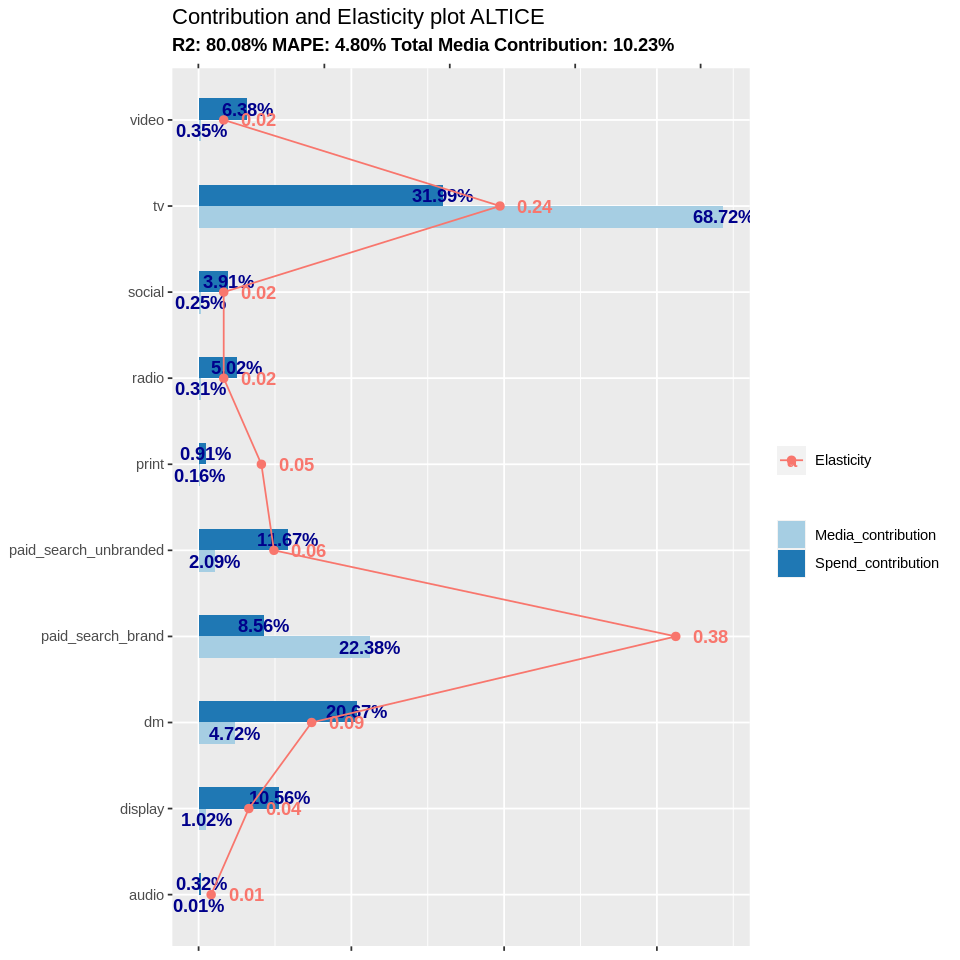

In [28]:
options(repr.plot.width=8, repr.plot.height = 8)
using_mean_plts$brand_plots$ALTICE

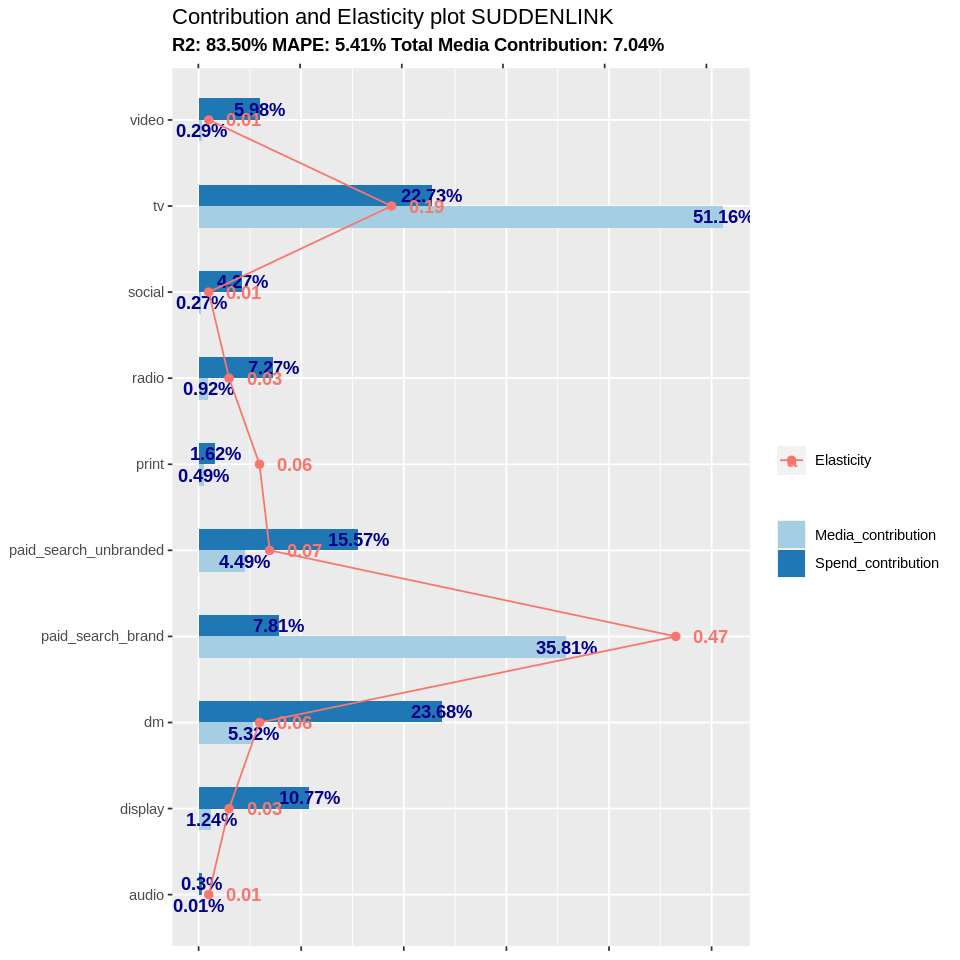

In [29]:
options(repr.plot.width=8, repr.plot.height = 8)
using_mean_plts$brand_plots$SUDDENLINK

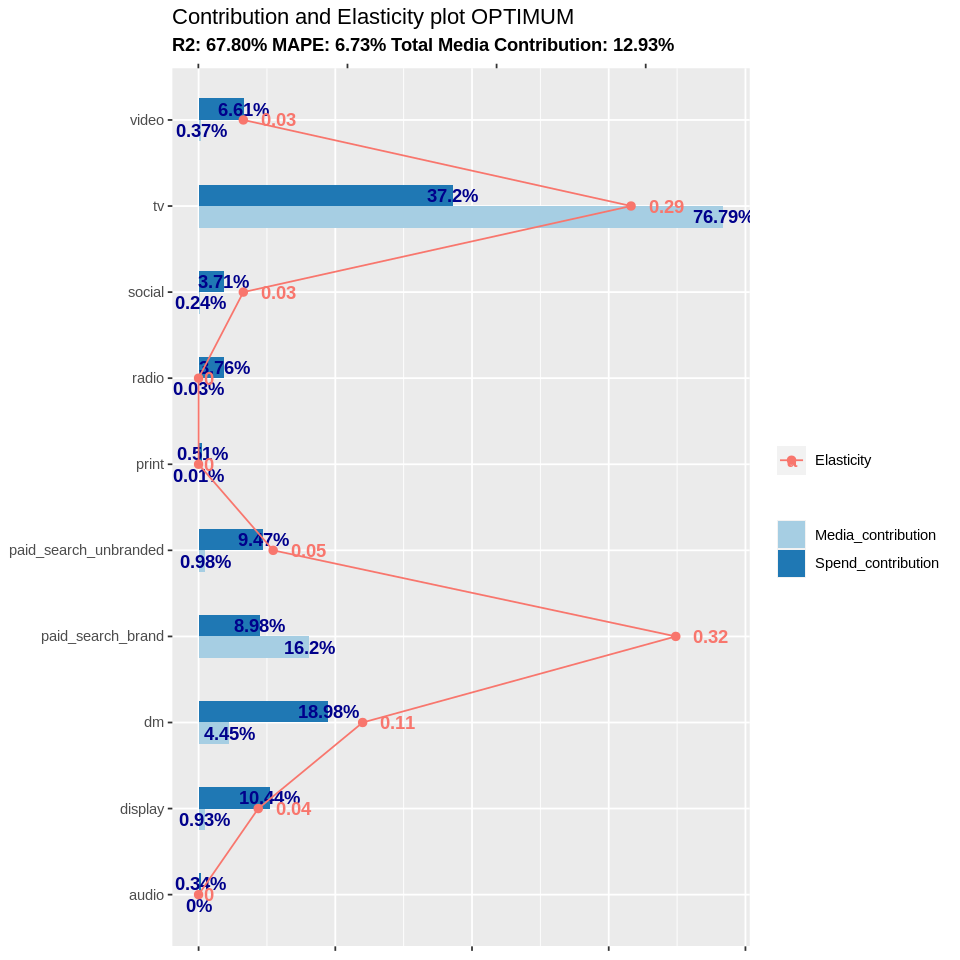

In [30]:
options(repr.plot.width=8, repr.plot.height = 8)
using_mean_plts$brand_plots$OPTIMUM

In [31]:
save(model_params,file = 'model_params/model_params_PP_44_10_C19_appr3_45_beta_res_xy995.rda')